# STATISTICAL MACHINE LEARNIGN PROJECT

In [408]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import xgboost as xgb

import shap
shap.initjs()

## Dataset

### Demographic input features:
* **Age**: the age group of the partecipants 
    * -0.95197: 18-24
    * -0.07854: 25-34
    * 0.49788: 35-44
    * 1.09449: 45-54
    * 1.82213: 55-64
    * 2.59171: 65+
* **Gender**
    * 0.48246: Female
    * -0.48246: Male
* **Education**: 
    * -2.43591: Left school before 16 years
    * -1.73790: Left school at 16 years
    * -1.43719: Left school at 17 years
    * -1.22751: Left school at 18 years
    * -0.61113: Some college or university, no certificate
    * -0.05921: Professional certificate/ diploma
    * 0.45468: University degree
    * 1.16365: Masters degree
    * 1.98437: Doctorate degree
* **Country**:
    * -0.57009: USA
    * 0.96082: UK
    * 0.24923: Canada
    * -0.09765: Australia
    * 0.21128: Republic of Ireland
    * -0.46841: New Zealand
    * -0.28519: Other
* **Ethnicity**:
    * -0.31685: White
    * -1.10702: Black
    * -0.50212: Asian
    * -0.22166: Mixed-White/Black
    * 0.12600: Mixed-White/Asian
    * 1.90725: Mixed-Black/Asian
    * 0.11440: Other

### Personality Scores features
These features are Z-scores (normalized values) representing the participant's performance on psychological tests compared to a norm.
* Value ~ 0: Average
* Positive Values: Above average traits (e.g., Higher Neuroticism or Sensation Seeking)
* Negative Values: Below average traits

The features are:
* **N** = **Neuroticism**: Tendency to experience negative emotions
* **E** = **Extravertion**: How outgoing, energetic, and assertive a person is
* **O** = **Openness**: Appreciation for art, emotion, adventure, and unusual ideas
* **A** = **Agreeableness**: Tendency to be compassionate, cooperative, and trusting rather than suspicious
* **C** = **Conscientiousness**: Tendency to be organized, dependable, and self-disciplined
* **Impulsive**: Acting without thinking
* **SS** = **Sensation Seeking**: Measures the need for varied, novel, and complex sensations and experiences 

In [409]:
# Import dataset
# features

features = [
    'ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity',
    'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',
    'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Choc', 'Coke', 'Crack',
    'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
    'Nicotine', 'Semeron', 'VSA'
]

input_features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
    'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS',]

# output
drugs = [
    'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Choc', 'Coke', 'Crack',
    'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
    'Nicotine', 'Semeron', 'VSA'
]
file_path = 'drug_consumption.data'
data = pd.read_csv(file_path, names=features, header=None)

# Semeron is a fictitious drug used to identify over-claimers
# We remove all instances where Semeron != CL0 and then remove the column
data = data[data['Semeron'] == 'CL0']
data.drop('Semeron', axis=1, inplace=True)
drugs.remove('Semeron')

# We simplify the dataframe into USER (1) and NON-USER (0)
for drug in drugs:
    data[drug] = data[drug].apply(lambda x: 1 if x in ['CL3','CL4','CL5','CL6'] else 0)

print(len(data))
tot_users = len(data)
data.head()

1877


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,0,1,0,0,0,0,1,0,1,0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,0,0,0,0,0,0,0,0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,0,0,0,0,0,0,0,0,0,0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,0,0,0,0,0,0,0,0,0,0


## Frequency of users per drug
We want to understand which drugs are imbalanced (either everyone uses them, or almost no one uses them).

### Absolute frequency

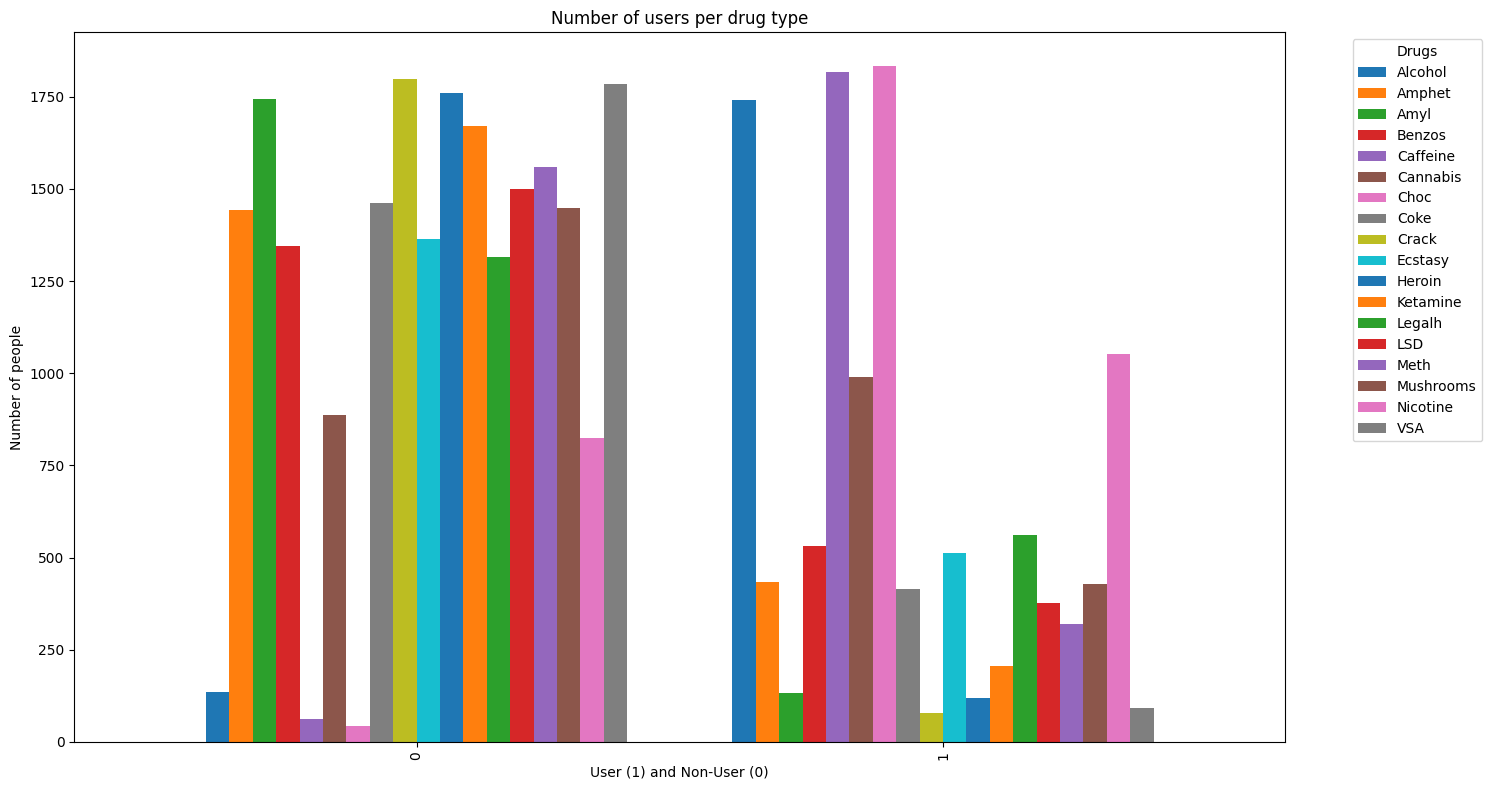

In [410]:
# Plot 1: absolute drug usage
users_per_drug = {drug: data[drug].value_counts().sort_index() for drug in drugs}
users_df = pd.DataFrame(users_per_drug).fillna(0).astype(int)
users_df.plot(kind='bar', figsize=(15,8), width=0.8)
plt.title('Number of users per drug type')
plt.xlabel('User (1) and Non-User (0)')
plt.ylabel('Number of people')
plt.legend(title='Drugs', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

### Relative frequency

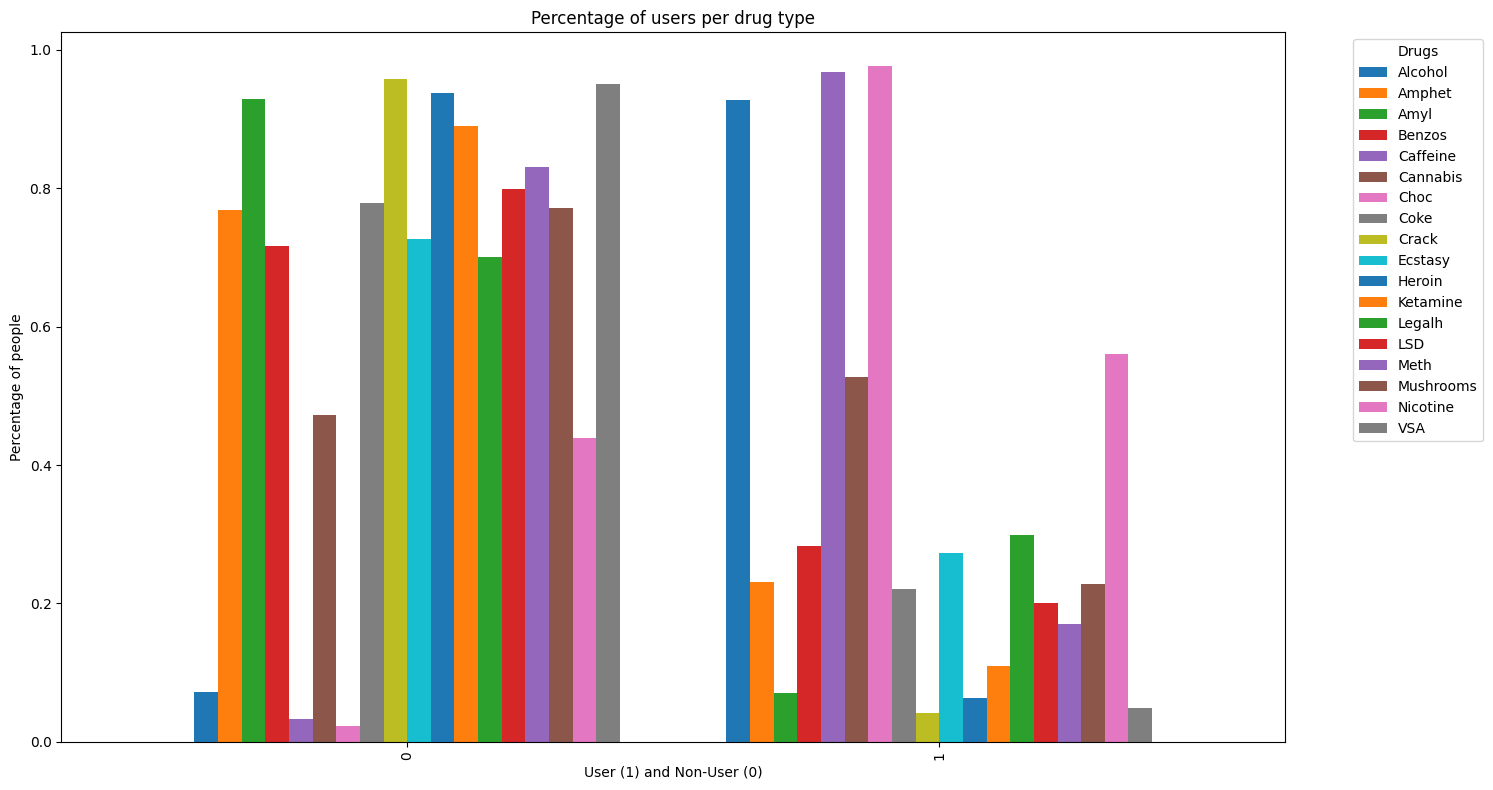

In [411]:
# Plot 2: relative drug usage
try:
    rel_users_df = users_df / tot_users
    rel_users_df.plot(kind='bar', figsize=(15,8), width=0.8)
    plt.title('Percentage of users per drug type')
    plt.xlabel('User (1) and Non-User (0)')
    plt.ylabel('Percentage of people')
    plt.legend(title='Drugs', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error while calculating or displaying relative frequences: {e}")

### Observations
Drugs with poor predictability because more than 95% of the people are users:
* Caffeine
* Alcohol
* Chocolate

The model will likely classify a new instance as a user.

Drugs that are hard to predict due to low usage rates (between 10%-20%)
* Crack
* Heroin
* Ketamine
* VSA

This would lead to generally poor predictive performance with a simple decision tree.

In [412]:
# Get rid of these drugs from the data set
imbalanced_drugs = ['Caffeine', 'Alcohol', 'Choc', 'Crack', 'Heroin', 'Ketamine', 'VSA']
data = data.drop(columns=imbalanced_drugs)
drugs = [x for x in drugs if x not in imbalanced_drugs]

display(data.head())


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Amyl,Benzos,Cannabis,Coke,Ecstasy,Legalh,LSD,Meth,Mushrooms,Nicotine
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,0,0,1,1,1,0,0,1,0,1
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,1,0,0,0,0,0,0,0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,0,1,0,0,0,0,0,0,0,0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,0,0,1,0,0,0,0,0,0,0


## Analysis of the distribution of the features
We aim at understanding if there are any features that can be dropped

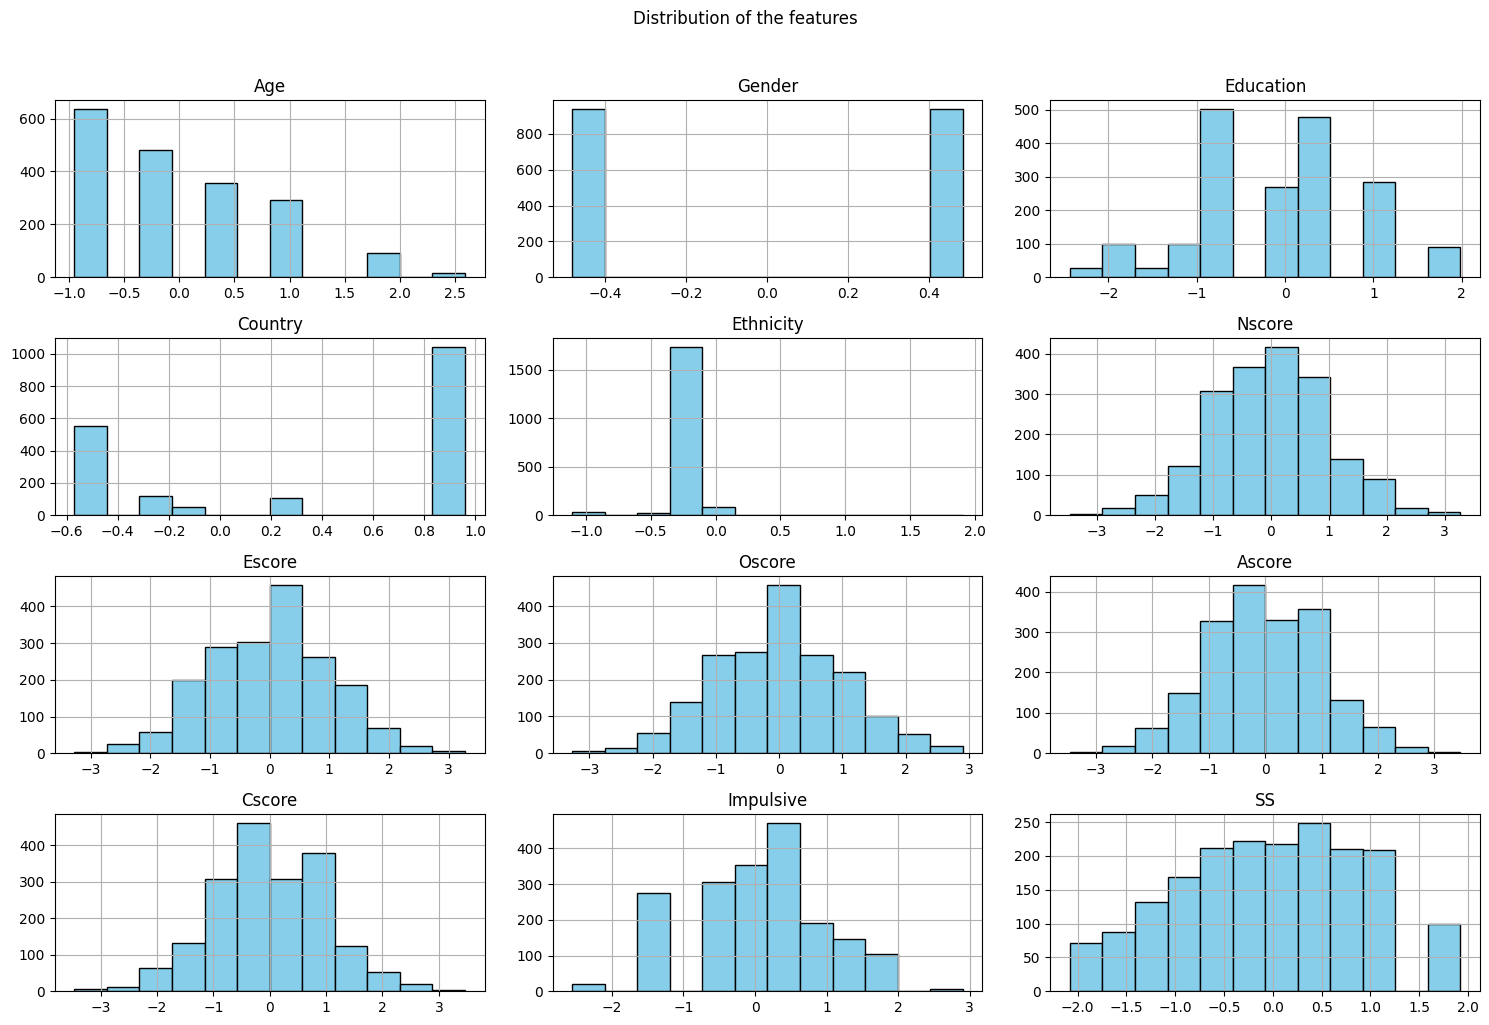

In [413]:
# create a subset dataframe
users_data_df = data[input_features]

# Plot histograms
users_data_df.hist(figsize=(15,10), bins=12, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of the features", y=1.02)
plt.tight_layout()
plt.show()

## Observations
Notice that for the two features country and ethnicity most of the feature values are concentrated in one or two classes (specifically, 'White' for ethnicity; 'USA' and 'UK' for country). In the article this observation lead to the dropping of the features so that it could be possible to focus more on personality traits.

In [414]:
features_to_drop = ['Country', 'Ethnicity']
data = data.drop(columns=features_to_drop)

input_features = [x for x in input_features if x not in features_to_drop]

## Correlation between features
Last but not least, it might be interesting to analyze if these features are correlated

<Axes: >

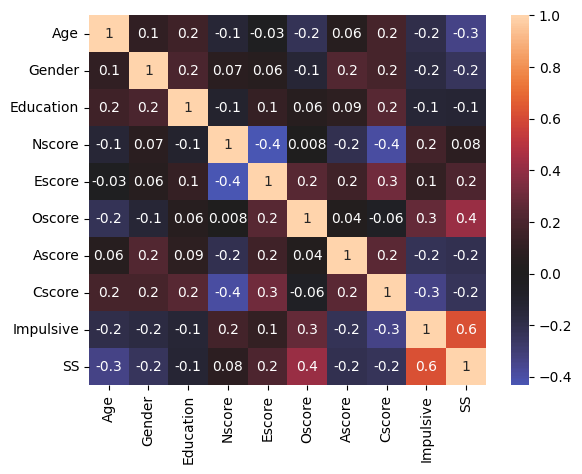

In [415]:
users_data_df = data[input_features]

corr_matrix = users_data_df.corr()

sns.heatmap(
    corr_matrix,
    center = 0,
    annot=True,
    fmt='.1g')

# Modelling
We will focus on 'Cannabis', the drug that from the paper looks like the most predictable.

The drugs for which a decision tree performed well is are: Legalh, Cannabis, LSD, Mushrooms.

We are predicting  282 instances


Target: ['Cannabis']
Confusion Matrix: 
 [[100  43]
 [ 32 107]]
Sensitivity (Recall for Users): 0.7698
Specificity (Recall for Non-Users): 0.6993
Precision: 0.7133

###############################

Example of a prediction
Instance: 


Age          0.49788
Gender       0.48246
Education   -0.05921
Nscore       0.31287
Escore      -0.57545
Oscore      -0.58331
Ascore      -0.91699
Cscore      -0.00665
Impulsive   -0.21712
SS          -1.18084
Name: 0, dtype: float64

Prediction:  0


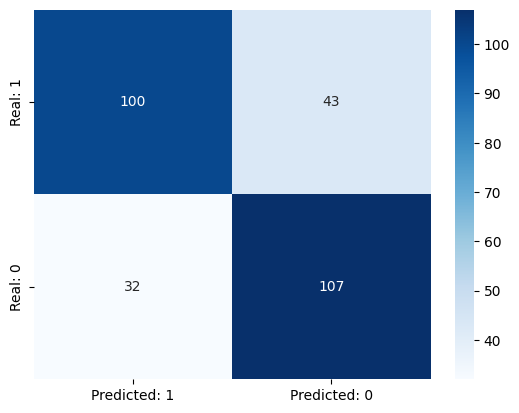

In [416]:
target_drug = ['Cannabis']
y = data[target_drug]
X = data[input_features]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size = 0.15,
        random_state = 42,
        shuffle = True
    )

num_predictions = len(X_test)
print("We are predicting ", num_predictions, "instances\n")

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model evaluation
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_df = pd.DataFrame(conf_mat, 
                           columns=['Predicted: 1', 'Predicted: 0'], 
                           index=['Real: 1', 'Real: 0'])
sns.heatmap(conf_mat_df, annot=True, fmt='d',cmap='Blues')

tn, fp, fn, tp = conf_mat.ravel()

# Compute metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (fp + tp) if (fp + tp) > 0 else 0

print(f"\nTarget: {target_drug}")
print("Confusion Matrix: \n", conf_mat)
print(f"Sensitivity (Recall for Users): {sensitivity:.4f}")
print(f"Specificity (Recall for Non-Users): {specificity:.4f}")
print(f"Precision: {precision:.4f}")

print("\n###############################")
print("\nExample of a prediction\nInstance: ")
display(X.iloc[0])
print("Prediction: ", y_pred[0])

### Modelling with XGBoost library
We try a different, more stable and more optimized library


Target: ['Cannabis']
Confusion Matrix: 
 [[107  36]
 [ 33 106]]
Sensitivity (Recall for Users): 0.7626
Specificity (Recall for Non-Users): 0.7483
Precision: 0.7465


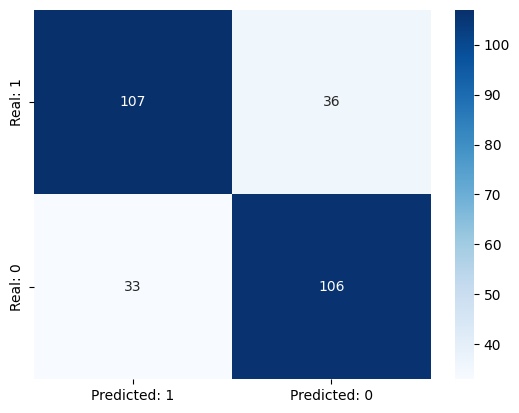

In [417]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size = 0.15,
        random_state = 42,
        shuffle = True
    )

model_xgb = xgb.XGBClassifier(objective="binary:logistic")
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

# Model evaluation
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_xgb)
conf_mat_df = pd.DataFrame(conf_mat, 
                           columns=['Predicted: 1', 'Predicted: 0'], 
                           index=['Real: 1', 'Real: 0'])
sns.heatmap(conf_mat_df, annot=True, fmt='d',cmap='Blues')

tn, fp, fn, tp = conf_mat.ravel()

# Compute metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (fp + tp) if (fp + tp) > 0 else 0

print(f"\nTarget: {target_drug}")
print("Confusion Matrix: \n", conf_mat)
print(f"Sensitivity (Recall for Users): {sensitivity:.4f}")
print(f"Specificity (Recall for Non-Users): {specificity:.4f}")
print(f"Precision: {precision:.4f}")

## SHAP values

In [418]:
# Evaluation
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

np.shape(shap_values.values)
#display(shap_values)

(282, 10, 2)

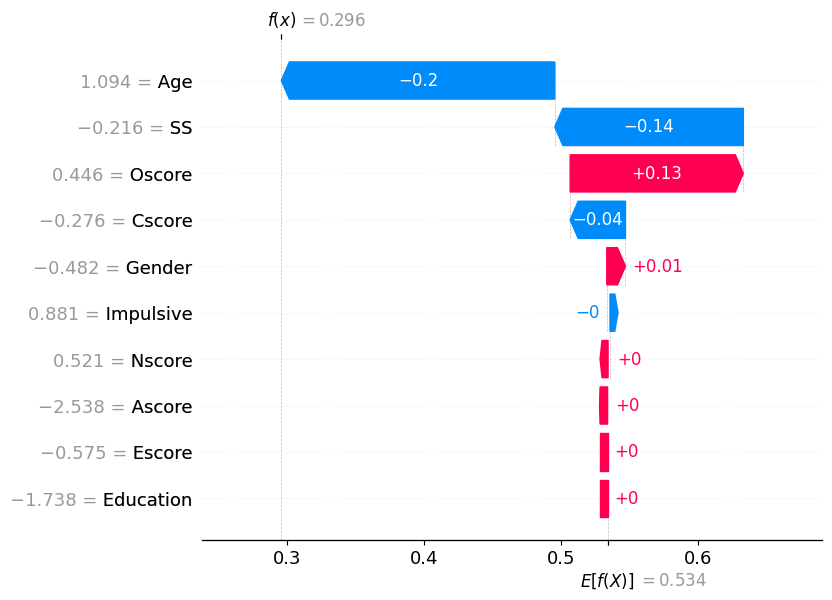

Actual target value:  Cannabis    1
Name: 1113, dtype: int64
Prediction:  0


In [419]:
# PLOTS
# Waterfall plot for first observation
ID_instance = 0


shap.plots.waterfall(shap_values[ID_instance, :, 1])
print('Actual target value: ', y_test.iloc[ID_instance])
print('Prediction: ', y_pred[ID_instance])

shap.plots.force(shap_values[ID_instance,:,1])


## General interpretation of the model

Waterfall plot and Force plot = understanding how the model has made individual predictions.

Absolute Mean SHAP and Stacked Force plot = understand the trends in general

Beeswarm plot = visualisation of all the SHAP values

Dependence plot = scatter plot of the SHAP values vs the feature values for a single feature. Useful if the feature has a non linear relationship with the target variable

### Mean SHAP values

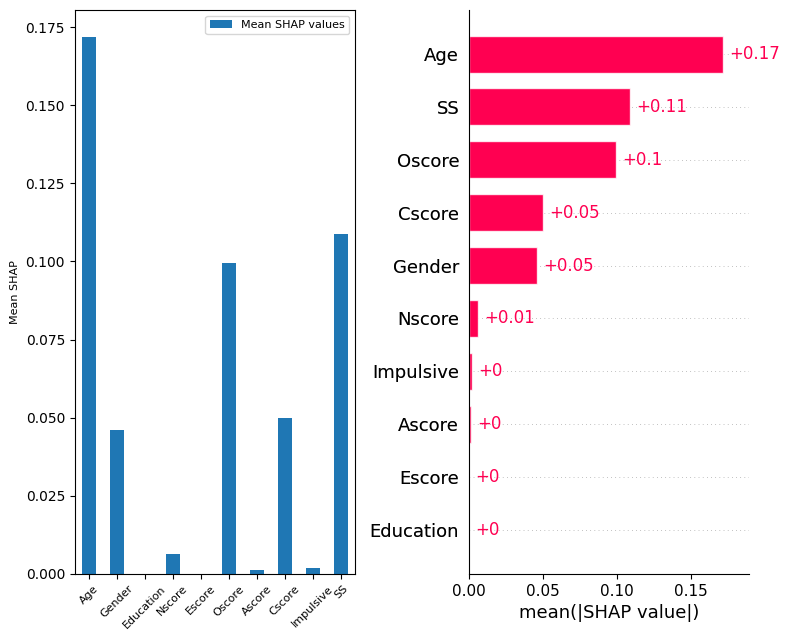

In [423]:
# We will create 2 graphs: they are the same. The difference is in the layout and in the number of instructions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

# First plot
mean_shap = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
shap_df = pd.DataFrame({"Mean SHAP values": mean_shap}, index=X_test.columns)
shap_df.plot.bar(ax=ax[0])
ax[0].set_ylabel("Mean SHAP", size=8)
ax[0].set_xticklabels(X_test.columns, rotation=45, size=8)
ax[0].legend(fontsize=8)

# Second plot
plt.sca(ax[1])
shap.plots.bar(shap_values[:,:,1], show=False)

plt.tight_layout()
plt.show()


### Stacked force plot

In [424]:
shap.plots.force(shap_values[0:150,:,1])

### Beeswarm plot

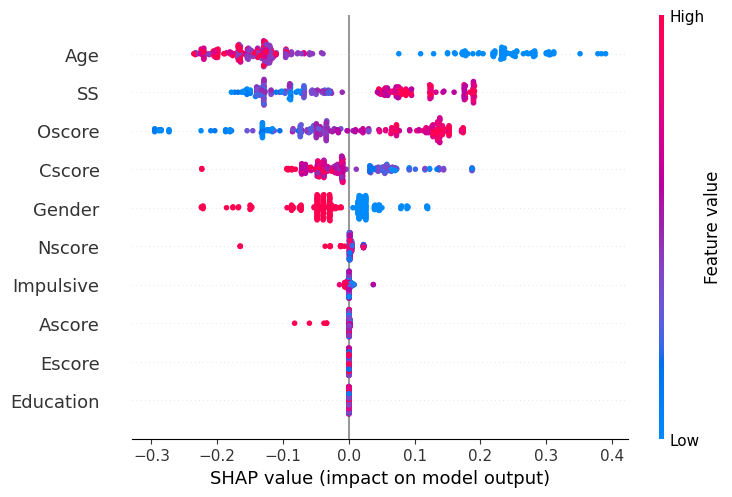

In [425]:
shap.plots.beeswarm(shap_values[:,:,1])

### Dependence plot

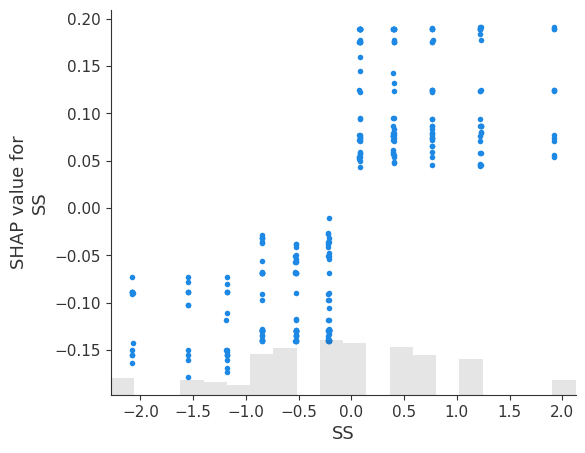

In [427]:
shap.plots.scatter(shap_values[:,"SS", 1])

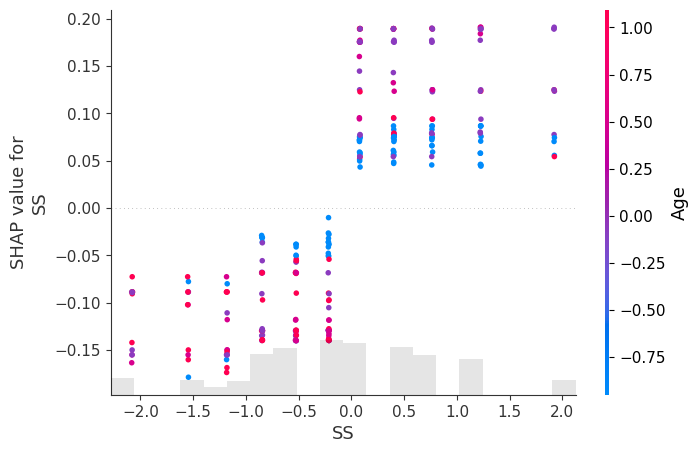

In [428]:
shap.plots.scatter(shap_values[:,"SS",1],
                   color = shap_values[:,"Age",1])